<a href="https://colab.research.google.com/github/amir1913/PUS2022_AMeydani/blob/main/HW5/REVISION_HW5_timeSeriesClustering_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering analysis on population trends

You are clustering the "shape" of time series to find trends, specifically, population growth trends. Do any countries stand out in the population growth trends in the past 60 years? are there groups of countries that have similar trends (and why?)

NOTE: your clusters may not be identical to mine!
## Imports

In [ ]:
import pandas as pd
import pylab as pl
import numpy as np

from sklearn import preprocessing
from sklearn import cluster

pl.rcParams['font.size'] = 18

do this to read an excel file with python
then restart the notebook

In [ ]:
pip install xlrd==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data processing

## Get the data

I wanted the data to be gotten from the WorldBank API directly but the link is down tonight (11/2) so I put the file on the shared drive. Mount your google drive and get it from `/content/drive/Shareddrives/PUS2022/data`. The file name is `SP.POP.TOTL?downloadformat=excel`

You are going to have to skip some rows (`skiprows=`) and ideally only use relevant columns (the country name and each year column from 1960, you can use `usecold=` or you can read everything in then throw away the columns you do not need). 

Finally, set the country name as the index for this dataframe. you can do that with `set_index()` passing the relevant column name as the argument (dont forget that you want to do it inplace! `inplace=True`)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#cd /content/drive/Shareddrives/PUS2022

In [ ]:
#reading in the data
pop_df = pd.read_excel('/content/drive/Shareddrives/PUS2022/data/SP.POP.TOTL?downloadformat=excel')
                       
pop_df.head()

,Data Source,World Development Indicators,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64
0,Last Updated Date,2022-02-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
4,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0


In [ ]:
pop_df.shape

(269, 65)

##Data Cleaning 
remove NaNs, remove any unwanted columns

In [ ]:

# I recommend you drop any column that is all NoN and any row that has any NaN 
# you control this (dropping only if all are, vs dropping if any is) with the keyord "any" of .dropna()
pop_df_clean = pop_df.dropna(how='any').dropna(axis='columns', how='all')

In [ ]:
# looking a little at the data
pop_df_clean.shape

(263, 65)

Six rows had nan values.

In [ ]:
pop_df_clean.head()

,Data Source,World Development Indicators,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64
2,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
4,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0
5,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,30117411.0,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0
6,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,...,360285439.0,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0


In [ ]:
new_header = pop_df_clean.iloc[0] #grab the first row for the header
pop_df_clean = pop_df_clean[1:] #take the data less the header row
pop_df_clean.columns = new_header #set the header row as the df header

In [ ]:
pop_df_clean

2,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
4,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0
5,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,30117411.0,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0
6,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,...,360285439.0,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0
7,Angola,AGO,"Population, total",SP.POP.TOTL,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,...,24220660.0,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1791000.0,1807106.0,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1775378.0
265,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5315351.0,5393034.0,5473671.0,5556767.0,5641598.0,5727745.0,...,23807586.0,24473176.0,25147112.0,25823488.0,26497881.0,27168210.0,27834811.0,28498683.0,29161922.0,29825968.0
266,South Africa,ZAF,"Population, total",SP.POP.TOTL,17099836.0,17524533.0,17965733.0,18423157.0,18896303.0,19384838.0,...,52003759.0,52832659.0,53687125.0,54544184.0,55386369.0,56207649.0,57009751.0,57792520.0,58558267.0,59308690.0
267,Zambia,ZMB,"Population, total",SP.POP.TOTL,3070780.0,3164330.0,3260645.0,3360099.0,3463211.0,3570466.0,...,14023199.0,14465148.0,14926551.0,15399793.0,15879370.0,16363449.0,16853608.0,17351714.0,17861034.0,18383956.0


In [ ]:
#pop_df_clean.tail()

Separate columns for a plot.

In [ ]:
pop_df_clean.drop(pop_df_clean.columns[[1, 2, 3]], axis=1, inplace=True)
pop_df_clean.set_index("Country Name", inplace=True)
pop_df_clean

2,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,1966.0,1967.0,1968.0,1969.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,57702.0,58044.0,58377.0,58734.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
Africa Eastern and Southern,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,152752671.0,156876454.0,161156430.0,165611760.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0
Afghanistan,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,10174840.0,10399936.0,10637064.0,10893772.0,...,30117411.0,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0
Africa Western and Central,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,109701811.0,112195950.0,114781116.0,117468741.0,...,360285439.0,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0
Angola,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,5781305.0,5774440.0,5771973.0,5803677.0,...,24220660.0,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kosovo,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,1163000.0,1191000.0,...,1791000.0,1807106.0,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1775378.0
"Yemen, Rep.",5315351.0,5393034.0,5473671.0,5556767.0,5641598.0,5727745.0,5816241.0,5907873.0,6001858.0,6097042.0,...,23807586.0,24473176.0,25147112.0,25823488.0,26497881.0,27168210.0,27834811.0,28498683.0,29161922.0,29825968.0
South Africa,17099836.0,17524533.0,17965733.0,18423157.0,18896303.0,19384838.0,19888259.0,20406863.0,20942147.0,21496075.0,...,52003759.0,52832659.0,53687125.0,54544184.0,55386369.0,56207649.0,57009751.0,57792520.0,58558267.0,59308690.0


## Scaling (standardizing)


Standardize the data: you are working with time series so you want each datapoint (=each country) to be mean 0 and standard deviaion 1 along the rows (that is axis 1)

You can use the `preprocessing.scale` function. Make sure you check! you want eavery country mean to be 0 and every country standard deviation to be 1...

Choose columns for standardization.

In [ ]:
#pop_stand = pop_df_clean[input_cols].copy()
#pop_stand[input_cols]

pop_stand = pd.DataFrame(preprocessing.scale(pop_df_clean, axis=1))
np.mean(pop_stand.iloc[0,:])
np.std(pop_stand.iloc[0,:])

#from sklearn.preprocessing import StandardScaler
#sc= StandardScaler()
#pop_stand = pd.DataFrame(sc.fit_transform(pop_df_clean))


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


1.0

# FBB good, make sure you inspect the values tho: you have lines of code that _take_ the mean and the std, but you are not printing them... what are they doing there?
```
np.mean(pop_stand.iloc[0,:])
np.std(pop_stand.iloc[0,:])
```

## Visualize the data

make a plot of the time series before scaling, and after scaling. What do you see in the scaled version that was lost before? Dont forget to write a caption!

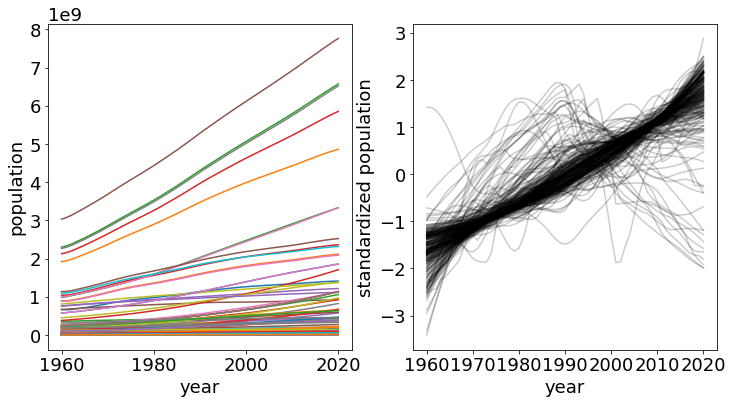

In [ ]:
# looking at the data
fig, ax = pl.subplots(1,2, figsize=(12,6))
pop_df_clean.T.plot(legend=False, ax=ax[0])
ax[1].plot(pop_stand.T, color="k", alpha=0.2)

ax[0].set_xlabel("year")
ax[0].set_ylabel("population")
ax[1].set_xlabel("year")
ax[1].set_ylabel("standardized population")
ax[1].set_xticks(range(0,70,10))
ax[1].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);


Fig. 1: Population of countries in time series (Left figure), and standardized format of them (Right figure) from 1960 until 2020. The left figure shows that most of the countries have same pattern in population change since the center of the graph has a high density.

# Make a cluster model with KMeans
Use kmeans (`sklearn.cluster.KMeans`) to cluster the data. Make 9 models for number of clusters = 2, 3, 4, 5, 6, 7, 8, 9, 10. 

For each model, fit the data and calculate the "inertia" which is 

# Use an elbow plot to figure out ideal cluster _n_ 

In [ ]:
iner = []
K = range(2,10)
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k)
    kmeanModel.fit(pop_stand)
    iner.append(kmeanModel.inertia_)

iner



[1249.5287124898719,
 846.602551696185,
 642.5573192964408,
 561.2284111940547,
 489.0995787469426,
 421.97419043165473,
 374.6182395288065,
 340.5766129334894]

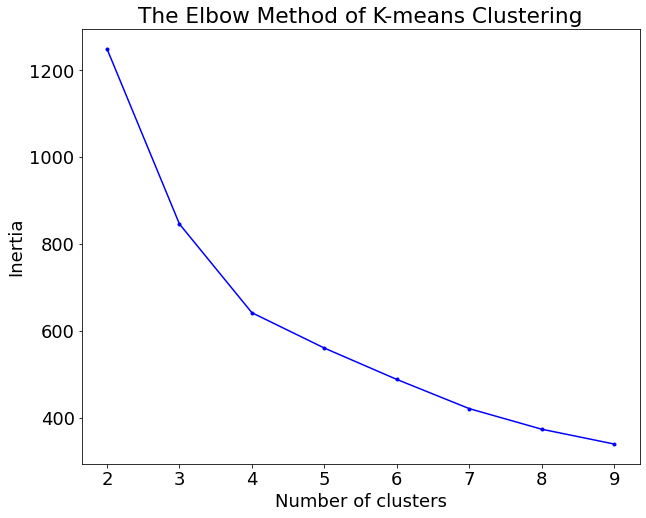

In [ ]:
# use the "inertia" (intracluster variance essentially) to make an Elbow plot: 
# inertia is the y axis, the number of clusters are the x axis.
# assess if the elbow plot shows an inflection, which you can use to determin the "right" number of clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(K, iner, 'b.-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method of K-means Clustering')
plt.show()

Figure 2: "Elbow plot" of k-means clustering of our time series. The y axis shows the sum of squared distances to the closest centroid (scikit calls this "inertia", Fed called it "variance"). The point where inertia/variance dramatically drops in an elbow plot is recommended as the preferred number of clusters; this line has a bit too much of a gradual descent to make an effective recommendation. I'm just going to keep using 4 because that's what we used in class.

## Pick a model
Pick the model you prefer from the suite of models above, plot the data for each cluster separately. If for example you have made 4 clusters, then you fould do:

In [ ]:
# time for a k-means cluster!!
numClust = 4
c =  cluster.KMeans(n_clusters = numClust).fit(pop_stand)
print(c.labels_)

[0 0 0 0 0 2 3 0 0 3 2 3 0 0 0 3 0 0 0 0 3 1 0 3 1 2 0 3 0 3 3 3 3 3 0 3 2
 0 3 3 3 0 0 0 0 3 0 0 3 3 3 2 0 0 2 3 3 2 0 3 3 3 3 3 3 3 3 0 3 3 1 0 3 0
 3 3 3 2 3 0 0 1 0 3 0 0 0 0 3 0 2 0 3 2 3 3 0 0 1 0 1 3 3 0 0 3 0 3 3 0 3
 0 0 0 3 3 0 2 2 0 3 0 0 0 3 3 0 0 0 3 3 3 0 0 3 3 3 3 3 3 1 0 1 0 3 3 0 2
 0 0 0 3 3 3 2 0 0 3 3 2 3 3 0 0 3 0 0 3 0 3 0 0 3 3 0 3 3 0 3 0 0 0 0 3 0
 3 0 2 0 2 3 3 3 3 3 3 0 1 2 0 3 0 0 0 0 0 0 3 3 0 2 0 0 0 0 0 0 2 2 0 3 3
 3 3 0 0 3 3 0 3 0 3 3 0 3 2 3 0 3 3 3 3 0 0 1 3 3 3 3 2 3 0 2 3 0 3 3 2 0
 3 0 3]


how many objects in each cluster?

In [ ]:
for i in range(numClust):
  print ("total items in cluster {:d}: {:d}".format(
      i+1, np.sum(c.labels_ == i)))

total items in cluster 1: 112
total items in cluster 2: 10
total items in cluster 3: 25
total items in cluster 4: 115


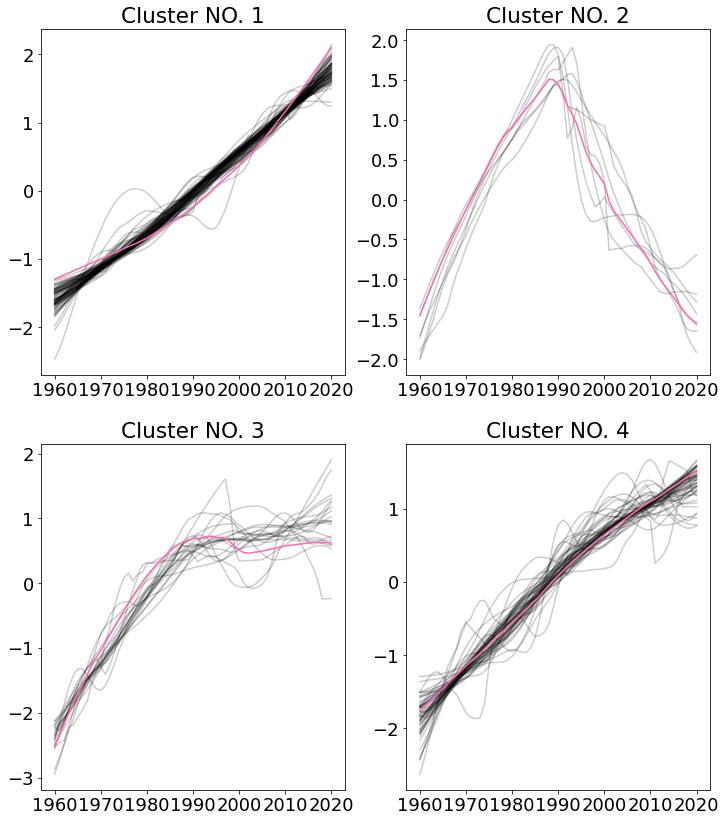

In [ ]:
fig,ax = pl.subplots(2,2, figsize=(12,14))


ax[0,0].set_title("Cluster NO. 1")
ax[0,0].set_xticks(range(0,70,10))
ax[0,0].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[0,0].plot(pop_stand[kmeanModel.labels_ == 0].T, "k", alpha=0.2);
ax[0,0].plot(c.cluster_centers_[0], color="hotpink")

ax[0,1].set_title("Cluster NO. 2")
ax[0,1].set_xticks(range(0,70,10))
ax[0,1].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[0,1].plot(pop_stand[kmeanModel.labels_ == 1].T, "k", alpha=0.2);
ax[0,1].plot(c.cluster_centers_[1], color="hotpink")

ax[1,0].set_title("Cluster NO. 3")
ax[1,0].set_xticks(range(0,70,10))
ax[1,0].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[1,0].plot(pop_stand[kmeanModel.labels_ == 2].T, "k", alpha=0.2);
ax[1,0].plot(c.cluster_centers_[2], color="hotpink")

ax[1,1].set_title("Cluster NO. 4")
ax[1,1].set_xticks(range(0,70,10))
ax[1,1].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[1,1].plot(pop_stand[kmeanModel.labels_ == 3].T, "k", alpha=0.2);
ax[1,1].plot(c.cluster_centers_[3], color="hotpink")

Figure 3: Results of using k-means clustering on the standardized data seen in Figure 1. The mean line for each cluster is visible in pink.

Cluster 1 is a a fairly linear upward trend with some outliers and cluster 4 a more curved upward trend. Cluster 2 and cluster 4 have fewer time series; 2 rises steadily before a big drop in the 1990s whereas the countries in 3 kind of hit a plateau around the 1990s. 

# FBB good

# Identifying the countries in the smallest clusters

plot the two smallest clusters with labels for the countries

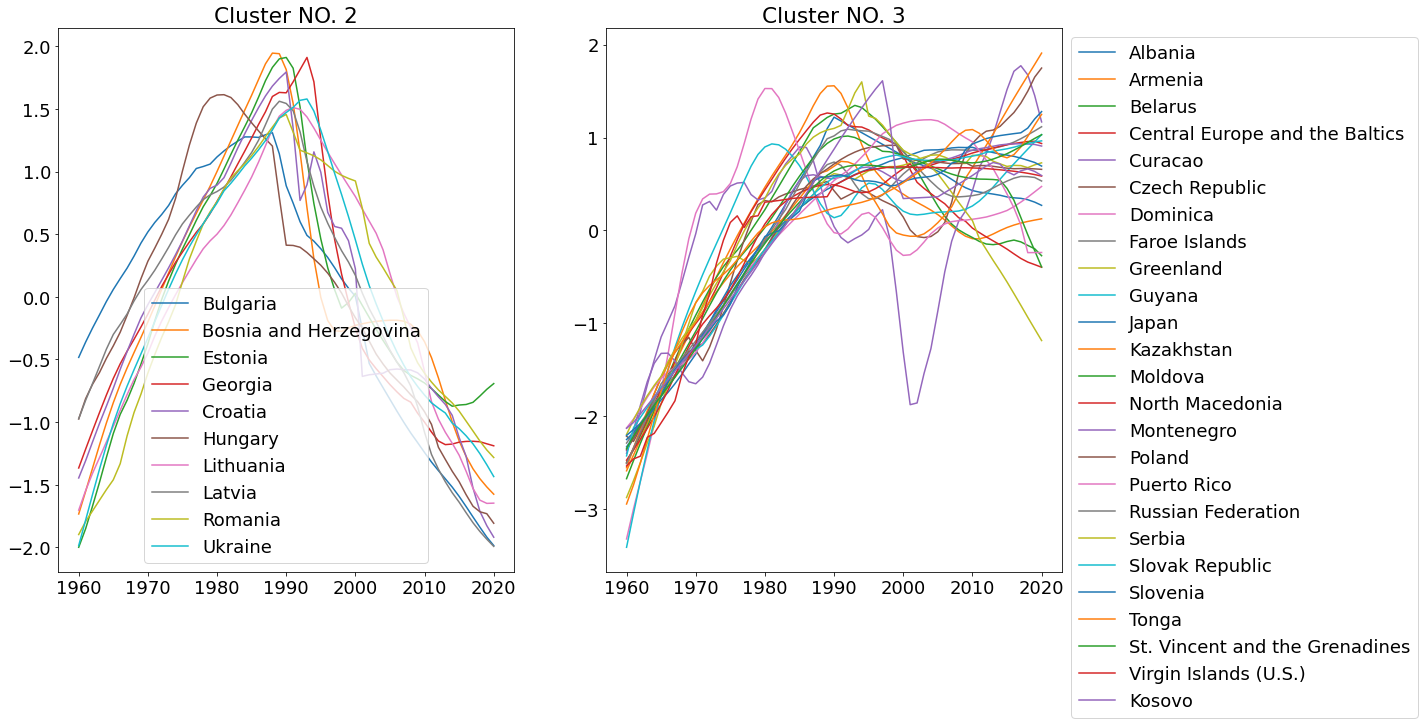

In [ ]:
fig,ax = pl.subplots(1,2, figsize=(18,10))

ax[0].set_title("Cluster NO. 2")
ax[0].set_xticks(range(0,70,10))
ax[0].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[0].plot(pop_stand[c.labels_ == 1 ].T);
ax[0].legend(labels=pop_df_clean.loc[c.labels_ == 1].index)

ax[1].set_title("Cluster NO. 3")
ax[1].set_xticks(range(0,70,10))
ax[1].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[1].plot(pop_stand[c.labels_ == 2 ].T);
# placing legend method via https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/
ax[1].legend(labels=pop_df_clean.loc[c.labels_ == 2].index, bbox_to_anchor=(1.0, 1.0), loc='upper left')


Figure 4: two clusters including a different group of countries with a similar pattern in their population change. The left figure shows a steep rise in the mean population until 1990 and a decline after this year, while the right figure shows a maintained mean population after this year.

---------------------------------------------------------------------------

Countries in the left cluster have a similar feature in their population pattern, indeed, they experienced a decline in the 1990s. The reason could be the dissolution of the Soviet Union which caused the process of internal disintegration within the Soviet Union (USSR) and resulted at the end of the USSR. Various countries emerged from the Soviet Union.

In comparison, the right figure includes countries with a maintained mean population after the 1990s. There is some exception among these countries, like Kosovo, which experienced war until 2000. This country had population growth after 2000. The documents prove an international military intervention this year leading to the peaceful condition of the country.

However, countries in the same cluster have close conditions with each other in terms of development and population growth; we can not put them exactly in the same groups. Among these countries, Japan is the counterexample in the case of development and GPD. In other words, the clustering based on population time series alone could not show the sustainability or economic condition of countries.

# FBB very good!

# Extra Credit: do it with anothe cluster method, agglomerative clustering or DBScan 